In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn import linear_model
import string
import math
import gzip
import random



In [2]:
df_rent = pd.read_json('renttherunway_final_data.json.gz', compression='gzip', lines=True)
print(len(df_rent))
df_rent.head()

192544


,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016"


### Imputating Missing Values

In [3]:
# nan present in 24% of rows -> will need to imputate values
len(df_rent.dropna())/len(df_rent)

0.7602470084759847

In [4]:
df_rent.isnull().any()

fit               False
user_id           False
bust size          True
item_id           False
weight             True
rating             True
rented for         True
review_text       False
body type          True
review_summary    False
category          False
height             True
size              False
age                True
review_date       False
dtype: bool

In [5]:
#imputating missing values

df_rent["bust size"] = df_rent["bust size"].fillna("Unknown")
df_rent["weight"] = df_rent["weight"].fillna("Unknown")
df_rent["rented for"] = df_rent["rented for"].fillna("other")
df_rent["body type"] = df_rent["body type"].fillna(df_rent["body type"].mode()[0])
df_rent["rating"] = df_rent["rating"].fillna(df_rent["rating"].mode()[0])
df_rent["age"] = df_rent["age"].fillna(df_rent["age"].median())
df_rent["height"] = df_rent["height"].fillna(df_rent["height"].mode()[0])

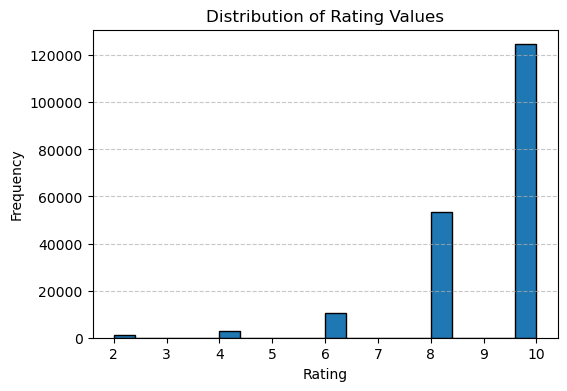

In [6]:
### To add to EDA

plt.figure(figsize=(6, 4))
plt.hist(df_rent['rating'], bins=20, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Rating Values')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [7]:
def weight_clean(row):
    try:
        return int(row.split('l')[0])
    except:
        return np.nan
df_rent['weight'] = df_rent['weight'].apply(weight_clean)  
df_rent["weight"] = df_rent["weight"].fillna(df_rent["weight"].median())

In [8]:
def height_to_meters(height):
    if pd.isna(height):
        return np.nan  # Handle NaN values
    import re
    match = re.match(r"(\d+)' (\d+)\"", height)  # Match feet and inches
    if not match:
        return np.nan  # Return NaN for invalid formats
    feet = int(match.group(1))
    inches = int(match.group(2))
    total_inches = feet * 12 + inches
    meters = total_inches * 0.0254  # Convert inches to meters
    return meters

# Apply the function to the column
df_rent['height_meters'] = df_rent['height'].apply(height_to_meters)

In [9]:
df_rent.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date,height_meters
0,fit,420272,34d,2260466,137.0,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016",1.7272
1,fit,273551,34b,153475,132.0,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013",1.6764
2,fit,360448,Unknown,1063761,135.0,10.0,party,This hugged in all the right places! It was a ...,hourglass,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0,"December 14, 2015",1.6256
3,fit,909926,34c,126335,135.0,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014",1.6510
4,fit,151944,34b,616682,145.0,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016",1.7526


# Baseline Model, Logistical Regression 

In [10]:
df_X = pd.get_dummies(df_rent, columns = ["category", "fit", "body type"])
df_X.drop(["rented for", "height", "review_date", "item_id", "user_id", "bust size", "review_text", "review_summary"],
          axis=1, inplace=True)
df_X.head()

,weight,rating,size,age,height_meters,category_ballgown,category_blazer,category_blouse,category_blouson,category_bomber,...,fit_fit,fit_large,fit_small,body type_apple,body type_athletic,body type_full bust,body type_hourglass,body type_pear,body type_petite,body type_straight & narrow
0,137.0,10.0,14,28.0,1.7272,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
1,132.0,10.0,12,36.0,1.6764,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
2,135.0,10.0,4,116.0,1.6256,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
3,135.0,8.0,8,34.0,1.6510,False,False,False,False,False,...,True,False,False,False,False,False,False,True,False,False
4,145.0,10.0,12,27.0,1.7526,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,False


In [14]:
X = df_X
y = df_rent["size"]

In [15]:
# 70-15-15 train-valid-test split
Ntrain = int(len(df_rent) *.7)
Ntest = int(len(df_rent)-(len(df_rent) -Ntrain)/2)

Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xvalid = X[Ntrain: Ntest].reset_index(drop = True)
yvalid = y[Ntrain: Ntest].reset_index(drop = True)
Xtest = X[Ntest:].reset_index(drop = True)
ytest = y[Ntest:].reset_index(drop = True)

In [16]:
df_X.shape

(192544, 83)

In [17]:
model = linear_model.LogisticRegression(C=1, max_iter = 200)
model.fit(Xtrain, ytrain)

/Users/josephguzman/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1, max_iter=200)

In [18]:
ypred = model.predict(Xvalid)

In [19]:
correct = 0
for i in range(len(yvalid)):
    if ypred[i] == yvalid[i]:
        correct += 1
correct/len(yvalid)


0.7537912886919188

#### super bad baseline....

#### what if we predicted fit?

# Bag of Words, Logistic Regression

In [21]:
wordCount = defaultdict(int)
punc = set(string.punctuation)

for rev in df_rent["review_text"]:
    r = rev.lower()
    r = "".join([c for c in r if c not in punc])
    words = r.split()
    for w in words:
        wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort(reverse=True)
words = [w[1] for w in counts[:2000]]
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

In [22]:
def feature(rev):
    feat = [0]*len(words)
    r = rev.lower()
    r = "".join([c for c in r if c not in punc])
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) # offset
    return feat

In [23]:
X = [feature(rev) for rev in df_rent["review_text"]]
y = df_rent["size"]


Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xvalid = X[Ntrain: Ntest]#.reset_index(drop = True)
yvalid = y[Ntrain: Ntest]#.reset_index(drop = True)
Xtest = X[Ntest:]#.reset_index(drop = True)
ytest = y[Ntest:]#.reset_index(drop = True)

In [24]:
model = linear_model.LogisticRegression(C=1, max_iter = 200)
model.fit(Xtrain, ytrain)

/Users/josephguzman/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1, max_iter=200)

In [25]:
ypred_1 = model.predict(Xvalid)

In [26]:
yvalid =  yvalid.reset_index(drop = True)

In [27]:
correct = 0
for i in range(len(yvalid)):
    if ypred_1[i] == yvalid[i]:
        correct += 1
correct/len(yvalid)


0.3230731943771207

#### hehehe not too bad

# TF-IDF, Logistics Regression

In [36]:
df = defaultdict(int)
for rev in df_rent["review_text"]:
    r = ''.join([c for c in rev.lower() if not c in punc])
    for w in set(r.split()):
        df[w] += 1

In [37]:
X = []

for rev in df_rent["review_text"]:
    review_list = []
    tf = defaultdict(int)
    r = rev.lower()
    r = "".join([c for c in r if c not in punc])
    tf_words = r.split()
    for t in tf_words:
        tf[t] += 1
    for w in words:
        review_list.append(tf[w] * math.log10(len(df_rent) / df[w]))
    X.append(review_list)

In [38]:
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xvalid = X[Ntrain: Ntest]#.reset_index(drop = True)
yvalid = y[Ntrain: Ntest]#.reset_index(drop = True)
Xtest = X[Ntest:]#.reset_index(drop = True)
ytest = y[Ntest:]#.reset_index(drop = True)

In [39]:
model = linear_model.LogisticRegression(C=1, max_iter = 100)
model.fit(Xtrain, ytrain)

/Users/josephguzman/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1)

In [40]:
ypred = model.predict(Xvalid)

In [41]:
yvalid =  yvalid.reset_index(drop = True)

In [42]:
correct = 0
for i in range(len(yvalid)):
    if ypred[i] == yvalid[i]:
        correct += 1
correct/len(yvalid)

0.8028529880202202

#### hmmmm its the same....

In [28]:
def rates(predictions, y):
    TP = [a and b for (a,b) in zip(predictions,y)]
    TN = [not a and not b for (a,b) in zip(predictions,y)]
    FP = [a and not b for (a,b) in zip(predictions,y)]
    FN = [not a and b for (a,b) in zip(predictions,y)]

    TP = sum(TP)
    TN = sum(TN)
    FP = sum(FP)
    FN = sum(FN)
    
    return TP, TN, FP, FN

In [29]:
def BER(predictions, y):
    TP, TN, FP, FN = rates(predictions, y)

    TPR = 0
    if TP > 0:
        TPR = TP / (TP + FN)
    TNR = 0
    if TN > 0:
        TNR = TN / (TN + FP)
    return 1 - 0.5 * (TPR + TNR)

In [30]:
y_pred_1 = []
for i in ypred_1:
    if i == 'fit':
        y_pred_1.append(0)
    elif i == 'large':
        y_pred_1.append(1)
    else:
        y_pred_1.append(2)

y_valid = []
for i in yvalid:
    if i == 'fit':
        y_valid.append(0)
    elif i == 'large':
        y_valid.append(1)
    else:
        y_valid.append(2)    


In [31]:
TP = rates(y_pred_1, y_valid)[0]
TN = rates(y_pred_1, y_valid)[1]
FP = rates(y_pred_1, y_valid)[2]
FN = rates(y_pred_1, y_valid)[3]


In [32]:
BER(y_pred_1, y_valid)

0.5

In [33]:
precision = TP / (TP + FP)
recall = TP / (TP + FN)

In [34]:
precision, recall

(1.0, 1.0)

In [35]:
F1 = 2 * (precision*recall) / (precision + recall)
F1

1.0

# Jaccard Similarity

In [36]:
fit_type_mapping = {
    'fit': 1,
    'small': 2,
    'large': 3,
    None: 0  # Handling NaN or missing values
}


df_rent['fit'] = df_rent['fit'].map(fit_type_mapping)


In [38]:
import pandas as pd
from collections import defaultdict
usersPerItem = defaultdict(set) # Maps an item to the users who rated it
itemsPerUser = defaultdict(set) # Maps a user to the items that they rated
fitDict = {}
sizeDict = {} # To retrieve a rating for a specific user/item pair


for index, row in df_rent.iterrows():
    user, item = row['user_id'], row['item_id']
    usersPerItem[item].add(user)
    itemsPerUser[user].add(item)
    sizeDict[(user, item)] = row['size']




In [43]:
userAverages = {}
itemAverages = {}

for u in itemsPerUser:
    rs = [sizeDict[(u,i)] for i in itemsPerUser[u]]
    userAverages[u] = sum(rs) / len(rs)
    
for i in usersPerItem:
    rs = [sizeDict[(u,i)] for u in usersPerItem[i]]
    itemAverages[i] = sum(rs) / len(rs)

In [52]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

In [40]:
def Cosine(i1, i2):
    # Between two items
    inter = usersPerItem[i1].intersection(usersPerItem[i2])
    numer = 0
    denom1 = 0
    denom2 = 0
    for u in inter:
        numer += sizeDict[(u,i1)]*sizeDict[(u,i2)]
    for u in usersPerItem[i1]:
        denom1 += sizeDict[(u,i1)]**2
    for u in usersPerItem[i2]:
        denom2 += sizeDict[(u,i2)]**2
    denom = math.sqrt(denom1) * math.sqrt(denom2)
    if denom == 0: return 0
    return numer / denom

In [45]:
reviewsPerUser = defaultdict(list)
reviewsPerItem = defaultdict(list)

for index, row in df_rent.iterrows():
    user, item = row['user_id'], row['item_id']
    reviewsPerItem[item].append(row)
    reviewsPerUser[user].append(row)

In [57]:
ratingMean = sum(df_rent['size']) / len(df_rent)
ratingMean

12.245175128801728

In [48]:
def mostSimilar(i, N):
    similarities = []
    users = usersPerItem[i]
    for i2 in usersPerItem:
        if i2 == i: continue
        sim = Jaccard(users, usersPerItem[i2])
#         sim = Pearson(i, i2) # Could use alternate similarity metrics straightforwardly
        similarities.append((sim,i2))
    similarities.sort(reverse=True)
    return similarities[:N]

In [49]:
query = df_rent['item_id'][0]

In [50]:
query

2260466

In [53]:
mostSimilar(query, 10)

[(0.05555555555555555, 2036606),
 (0.05263157894736842, 1440450),
 (0.046511627906976744, 211146),
 (0.045454545454545456, 528243),
 (0.04, 2286628),
 (0.03571428571428571, 2048890),
 (0.03571428571428571, 1964998),
 (0.03571428571428571, 1940267),
 (0.03571428571428571, 1862873),
 (0.03571428571428571, 849722)]

In [238]:
round(1.39, 0)

1.0

In [63]:
def predictSize(user,item):
    size = []
    similarities = []
    for d in reviewsPerUser[user]:
        i2 = d['item_id']
        if i2 == item: continue
        size.append(d['size'] - itemAverages[i2])
        similarities.append(Jaccard(usersPerItem[item],usersPerItem[i2]))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(size,similarities)]
        return itemAverages[item] + sum(weightedRatings) / sum(similarities) 
    else:
        # User hasn't rated any similar items
        return ratingMean

In [64]:
u,i = df_rent['user_id'][0], df_rent['item_id'][100]
u,i

(420272, 224876)

In [65]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

In [66]:
alwaysPredictMean = [ratingMean for index, row in df_rent.iterrows()]

In [67]:
simPredictions = [predictSize(row['user_id'], row['item_id']) for index, row in df_rent.iterrows()]

In [ ]:
new_simPredictions = []
for i in simPredictions:
    if i <= 1.0:
        new_simPredictions.append(1.0)
    elif i >= 3.0:
        new_simPredictions.append(3.0)
    else:
        new_simPredictions.append(i)


        

In [ ]:
set(simPredictions)

In [68]:
labels = df_rent['size'].to_list()
labels

[14,
 12,
 4,
 8,
 12,
 8,
 4,
 8,
 21,
 1,
 12,
 8,
 8,
 20,
 2,
 20,
 20,
 12,
 8,
 21,
 12,
 12,
 20,
 1,
 8,
 8,
 4,
 4,
 8,
 4,
 8,
 4,
 8,
 8,
 17,
 12,
 16,
 1,
 8,
 8,
 14,
 12,
 28,
 20,
 4,
 8,
 8,
 28,
 4,
 14,
 12,
 4,
 12,
 8,
 8,
 4,
 20,
 20,
 8,
 12,
 36,
 4,
 8,
 20,
 14,
 4,
 8,
 4,
 16,
 8,
 20,
 20,
 4,
 35,
 12,
 8,
 12,
 16,
 8,
 21,
 24,
 20,
 24,
 24,
 8,
 12,
 8,
 12,
 12,
 12,
 12,
 8,
 16,
 16,
 16,
 12,
 14,
 15,
 4,
 20,
 16,
 8,
 4,
 16,
 5,
 1,
 4,
 8,
 8,
 4,
 51,
 32,
 8,
 16,
 16,
 23,
 48,
 12,
 4,
 16,
 8,
 20,
 4,
 12,
 21,
 12,
 8,
 1,
 12,
 20,
 4,
 24,
 12,
 8,
 4,
 8,
 28,
 20,
 8,
 16,
 12,
 4,
 14,
 51,
 1,
 24,
 8,
 45,
 8,
 1,
 24,
 24,
 24,
 12,
 24,
 1,
 35,
 20,
 9,
 4,
 14,
 12,
 17,
 24,
 16,
 8,
 8,
 12,
 12,
 8,
 4,
 4,
 20,
 8,
 24,
 14,
 16,
 12,
 8,
 24,
 12,
 4,
 13,
 14,
 8,
 16,
 8,
 34,
 20,
 8,
 12,
 4,
 45,
 8,
 4,
 12,
 4,
 24,
 12,
 24,
 12,
 12,
 24,
 1,
 39,
 24,
 20,
 1,
 12,
 16,
 8,
 1,
 8,
 8,
 12,
 7,
 8,
 14,
 8,
 8

In [69]:
MSE(alwaysPredictMean, labels)

72.16255514458094

In [70]:
MSE(simPredictions, labels)


45.55033235873522

In [261]:
from sklearn.metrics import accuracy_score

# True labels (y_true) and predicted labels (y_pred)
accuracy = accuracy_score(simPredictions, labels)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 63.91%


In [274]:
df_rent

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,1,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,1,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"
2,1,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0,"December 14, 2015"
3,1,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014"
4,1,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192539,1,66386,34dd,2252812,140lbs,10.0,work,Fit like a glove!,hourglass,LOVE IT!!! First Item Im thinking of buying!,jumpsuit,"5' 9""",8,42.0,"May 18, 2016"
192540,1,118398,32c,682043,100lbs,10.0,work,The pattern contrast on this dress is really s...,petite,LOVE it!,dress,"5' 1""",4,29.0,"September 30, 2016"
192541,1,47002,36a,683251,135lbs,6.0,everyday,"Like the other DVF wraps, the fit on this is f...",straight & narrow,"Loud patterning, flattering fit",dress,"5' 8""",8,31.0,"March 4, 2016"
192542,1,961120,36c,126335,165lbs,10.0,wedding,This dress was PERFECTION. it looked incredib...,pear,loved this dress it was comfortable and photog...,dress,"5' 6""",16,31.0,"November 25, 2015"


# Word2vec

In [ ]:
fit_type_mapping = {
    'fit': 1,
    'small': 2,
    'large': 3,

In [284]:
average_size = df_rent.groupby('fit')['size'].median()

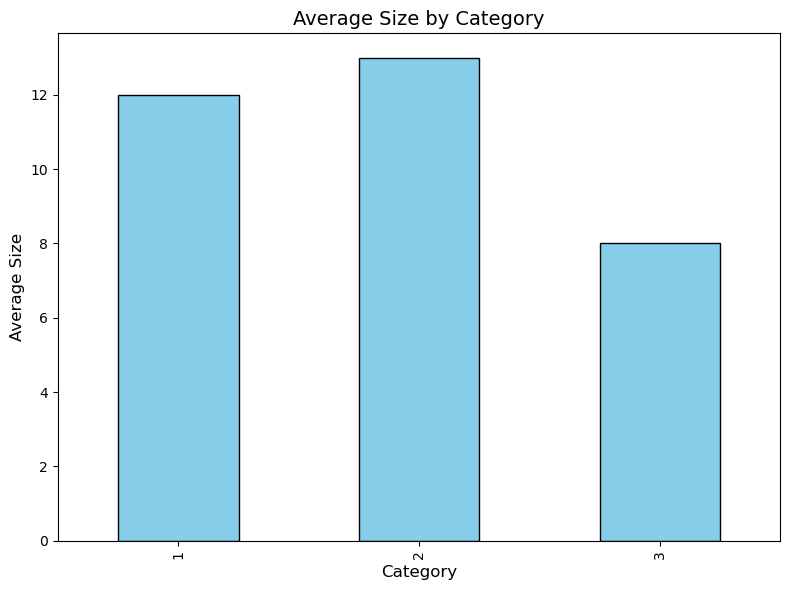

In [285]:
plt.figure(figsize=(8, 6))
average_size.plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Average Size by Category', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Average Size', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [267]:
itemStyles = {} # Style of each item
categories = set() # Set of item categories
reviewsPerUser = defaultdict(list)
itemIdToName = {} # Map an ID to the name of the product

In [ ]:
z = open(dataDir + "beer_50000.json")

reviews = []
reviewDicts = []

for l in z:
    d = eval(l)
    reviews.append(d['review/text'])
    beerStyles[d['beer/beerId']] = d['beer/style']
    categories.add(d['beer/style'])
    beerIdToName[d['beer/beerId']] = d['beer/name']
    reviewsPerUser[d['user/profileName']].append((d['review/timeUnix'], d['beer/beerId']))
    reviewDicts.append(d)
    if len(reviews) == 50000:
        break